# **Product Review Sentiment Analysis**
The goal of this project is to analyse customer reviews to determine their sentiment (positive, negative or neutral) based on the text content of the reviews and associated metadata. This will help in understanding customer feedback, identifying product strengths and weaknesses and improving the overall customer experience by offering actionable insights.

---

### **Problem Statement**
E-commerce platforms like Amazon, Jumia, Konga, Ebay, Ali Express and other online retailers in Nigeria and beyond collect millions of product reviews daily. These reviews are rich sources of customer feedback but are often unstructured, making manual analysis time-consuming and inefficient. Companies often need to quickly interpret the sentiments expressed in these reviews to understand how customers feel about their products, identify key pain points and adjust their business strategies accordingly. However, sorting through vast amounts of text data to understand customer sentiment (positive, neutral, or negative) poses a significant challenge. This project aims to automate the process of sentiment analysis using machine learning (ML) and natural language processing (NLP) techniques. By automating sentiment detection, businesses can gain real-time insights from reviews, leading to better decision-making, improved product offerings and enhanced customer satisfaction.

---

### **Key Steps in the Project**

1. **Data Collection**: Utilise the provided dataset containing customer reviews and associated metadata, such as star ratings and product categories.
2. **Data Preprocessing**: Handle missing data, clean text (e.g remove noise and irrelevant symbols) and standardise review content.
3. **Sentiment Labelling**: Use star ratings to label reviews as negative (1-2 stars), neutral (3 stars) or positive (4-5 stars).
4. **Exploratory Data Analysis (EDA)**:  Visualise the distribution of sentiments across different product categories and review ratings.
5. **Feature Extraction and Text Processing**: Convert review text into numerical features using tokenization, stopword removal and TF-IDF vectorization.
6. **Model Selection and Model Training**: Train a machine learning model (such as logistic regression, random forest or neural networks) to predict review sentiment based on extracted features.
7. **Model Evaluation**: Assess model performance using accuracy, precision, recall and F1 score to ensure reliable sentiment predictions.
8. **Performance Metrics**: Analyse metrics like confusion matrix and detailed performance scores to understand the strengths and weaknesses of the model.
9. **Building a Sentiment Analysis Dashboard with Streamlit and Real-Time Sentiment Prediction**: Create an interactive dashboard to visualise sentiment distribution and allow users to input reviews for real-time sentiment predictions.
10. **Business Insights and Recommendations**: Provide actionable insights and recommendations to businesses to improve product offerings based on patterns identified in customer feedback.

### **Step 1: Importing Required Libraries and Data Collection** ###

In [86]:
# Importing necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
import joblib
import warnings
from collections import Counter
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix

# Optional: Text preprocessing
import nltk
nltk.download('stopwords')
nltk.download('punkt')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# Optional: For creating word clouds if needed
from wordcloud import WordCloud

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\USER\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\USER\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [62]:
# Load the dataset with the correct delimiter
file_path = r"C:\Users\USER\Downloads\Sentiment Analysis for Product Reviews\Amazon Product Review.txt"
data = pd.read_csv(file_path, delimiter=",", encoding="utf-8")

# Check the columns in the dataset
print("Columns in the dataset:")
print(data.columns)

# Display the first few rows of the dataset to verify its structure
print(data.head())

Columns in the dataset:
Index(['marketplace', 'customer_id', 'review_id', 'product_id',
       'product_parent', 'product_title', 'product_category', 'star_rating',
       'helpful_votes', 'total_votes', 'vine', 'verified_purchase',
       'review_headline', 'review_body', 'review_date', 'sentiment'],
      dtype='object')
  marketplace  customer_id       review_id  product_id  product_parent  \
0          US     11555559  R1QXC7AHHJBQ3O  B00IKPX4GY         2693241   
1          US     31469372  R175VSRV6ZETOP  B00IKPYKWG         2693241   
2          US     26843895  R2HRFF78MWGY19  B00IKPW0UA         2693241   
3          US     19844868   R8Q39WPKYVSTX  B00LCHSHMS         2693241   
4          US      1189852  R3RL4C8YP2ZCJL  B00IKPZ5V6         2693241   

                           product_title product_category  star_rating  \
0  Fire HD 7, 7" HD Display, Wi-Fi, 8 GB               PC            5   
1  Fire HD 7, 7" HD Display, Wi-Fi, 8 GB               PC            3   
2  Fire 

In [63]:
# Rename columns if necessary
data.columns = data.columns.str.strip()  # Remove any leading/trailing spaces

### **Step 2 - Data Preprocessing** ###

In [64]:
# Drop rows with missing values in 'review_headline' or 'review_body'
data.dropna(subset=['review_headline', 'review_body'], inplace=True)

# Function to clean text data
def clean_text(text):
    text = re.sub(r'<.*?>', '', text)  # Remove HTML tags
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
    text = re.sub(r'\d+', '', text)      # Remove numbers
    text = text.lower()                   # Convert to lowercase
    stop_words = set(stopwords.words('english'))
    text = ' '.join([word for word in text.split() if word not in stop_words])
    return text

# Apply the clean_text function to 'review_headline' and 'review_body'
data['cleaned_review_headline'] = data['review_headline'].apply(clean_text)
data['cleaned_review_body'] = data['review_body'].apply(clean_text)

# Clean extra spaces
data['cleaned_review_headline'] = data['cleaned_review_headline'].str.replace(r'\s+', ' ', regex=True).str.strip()
data['cleaned_review_body'] = data['cleaned_review_body'].str.replace(r'\s+', ' ', regex=True).str.strip()

# Verify the new columns
print("Cleaned Review Headline and Body:")
print(data[['cleaned_review_headline', 'cleaned_review_body']].head())

Cleaned Review Headline and Body:
                             cleaned_review_headline  \
0                                         five stars   
1  lots ads slow processing speed occasionally sh...   
2                                well thought device   
3  appsgames looking forward using compatible tab...   
4                                         five stars   

                                 cleaned_review_body  
0                                         great love  
1  lots adsslow processing speedoccasionally shut...  
2  excellent unit versatility tablet besides comp...  
3  bought amazon prime ended buying gb one camera...  
4         amazon products continue meet expectations  


### **Step 3 - Sentiment Labelling** ###

In [65]:
# Function to label sentiment based on star ratings
def label_sentiment(star_rating):
    if star_rating in [1, 2]:
        return 'negative'
    elif star_rating == 3:
        return 'neutral'
    elif star_rating in [4, 5]:
        return 'positive'
    else:
        return 'unknown'  # In case of unexpected values

# Apply the function to the 'star_rating' column
data['sentiment_label'] = data['star_rating'].apply(label_sentiment)

# Verify the new column
print("Sentiment labels based on star ratings:")
print(data[['star_rating', 'sentiment_label']].head())

Sentiment labels based on star ratings:
   star_rating sentiment_label
0            5        positive
1            3         neutral
2            5        positive
3            4        positive
4            5        positive


### **Step 4 - Exploratory Data Analysis (EDA)** ###

<Figure size 1600x700 with 0 Axes>

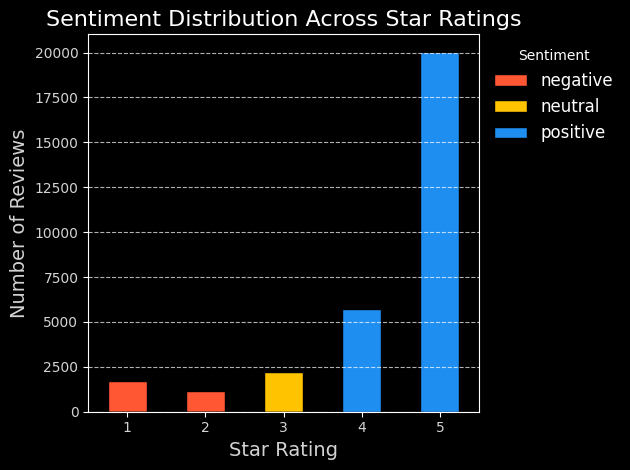

In [66]:
# 1. Sentiment Distribution Across Star Ratings
plt.style.use('dark_background')  # Set a style with a dark background

# Count the sentiment labels for each star rating
sentiment_counts_by_rating = data.groupby('star_rating')['sentiment_label'].value_counts().unstack().fillna(0)

# Plot the distribution of sentiment across star ratings
plt.figure(figsize=(16, 7))
sentiment_counts_by_rating.plot(kind='bar', stacked=True, color=['#FF5733', '#FFC300', '#1F8EF1'], edgecolor='black')
plt.title('Sentiment Distribution Across Star Ratings', fontsize=16, color='white')
plt.xlabel('Star Rating', fontsize=14, color='lightgray')
plt.ylabel('Number of Reviews', fontsize=14, color='lightgray')
plt.xticks(rotation=0, color='lightgray')
plt.yticks(color='lightgray')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(title='Sentiment', fontsize=12, bbox_to_anchor=(1, 1), loc='upper left', frameon=False)
plt.tight_layout()
plt.show()

<Figure size 1800x800 with 0 Axes>

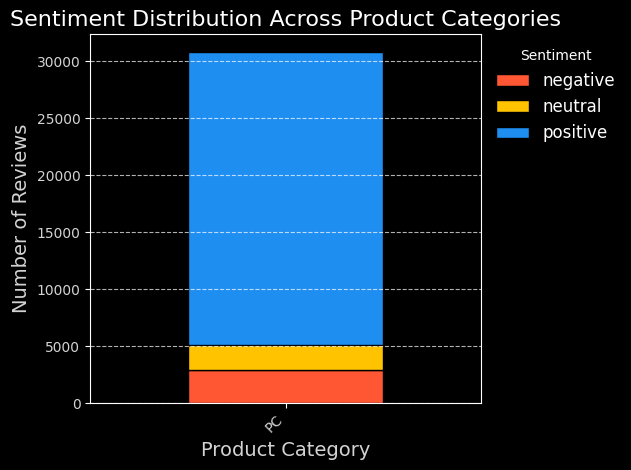

In [67]:
# 2. Sentiment Distribution Across Product Categories

plt.figure(figsize=(18, 8))  # Set figure size for product categories
sentiment_counts_by_category = data.groupby('product_category')['sentiment_label'].value_counts().unstack().fillna(0)

# Plot the distribution of sentiment across product categories
sentiment_counts_by_category.plot(kind='bar', stacked=True, color=['#FF5733', '#FFC300', '#1F8EF1'], edgecolor='black')
plt.title('Sentiment Distribution Across Product Categories', fontsize=16, color='white')
plt.xlabel('Product Category', fontsize=14, color='lightgray')
plt.ylabel('Number of Reviews', fontsize=14, color='lightgray')
plt.xticks(rotation=45, ha='right', color='lightgray')
plt.yticks(color='lightgray')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(title='Sentiment', fontsize=12, bbox_to_anchor=(1, 1), loc='upper left', frameon=False)
plt.tight_layout()
plt.show()

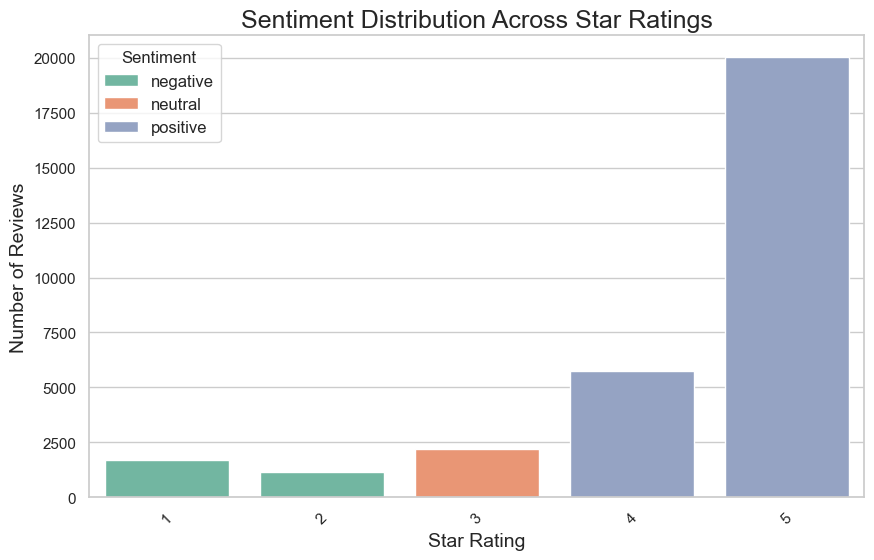

In [74]:
# 3. Star Rating Distribution by Sentiment
# Count plot for sentiment distribution across star ratings
plt.figure(figsize=(10, 6))
sns.countplot(data=data, x='star_rating', hue='sentiment_label', palette='Set2')
plt.title('Sentiment Distribution Across Star Ratings', fontsize=18)
plt.xlabel('Star Rating', fontsize=14)
plt.ylabel('Number of Reviews', fontsize=14)
plt.legend(title='Sentiment', fontsize=12)
plt.xticks(rotation=45)
plt.show()

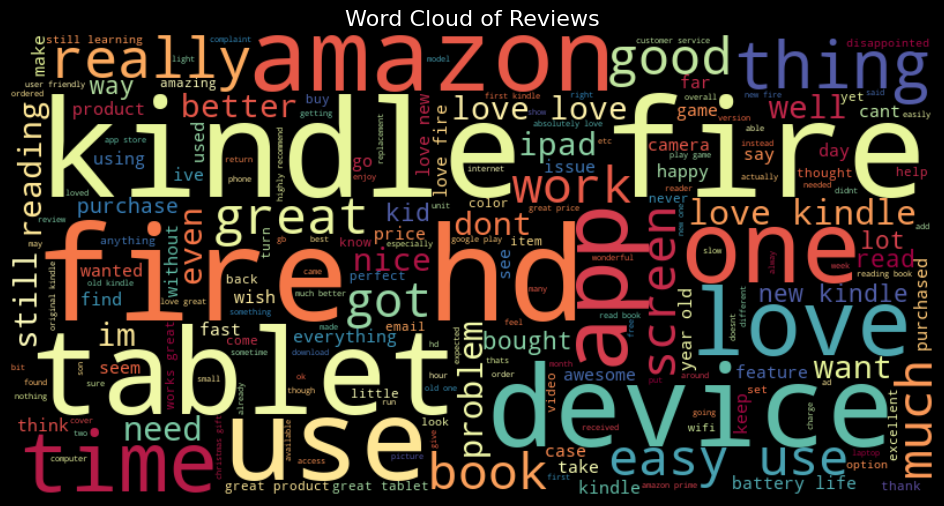

In [69]:
# 4. Perform Basic Text Analysis - Word Cloud
# Combine all cleaned reviews into a single string
all_reviews = ' '.join(data['cleaned_review_body'])

# Generate a word cloud with a unique color scheme
wordcloud = WordCloud(
    width=800,
    height=400,
    background_color='black',
    colormap='Spectral',
    contour_color='white',
    contour_width=1,
    random_state=42  # Ensures reproducibility
).generate(all_reviews)

# Display the word cloud
plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # Hide axes
plt.title('Word Cloud of Reviews', fontsize=16, color='white')
plt.show()

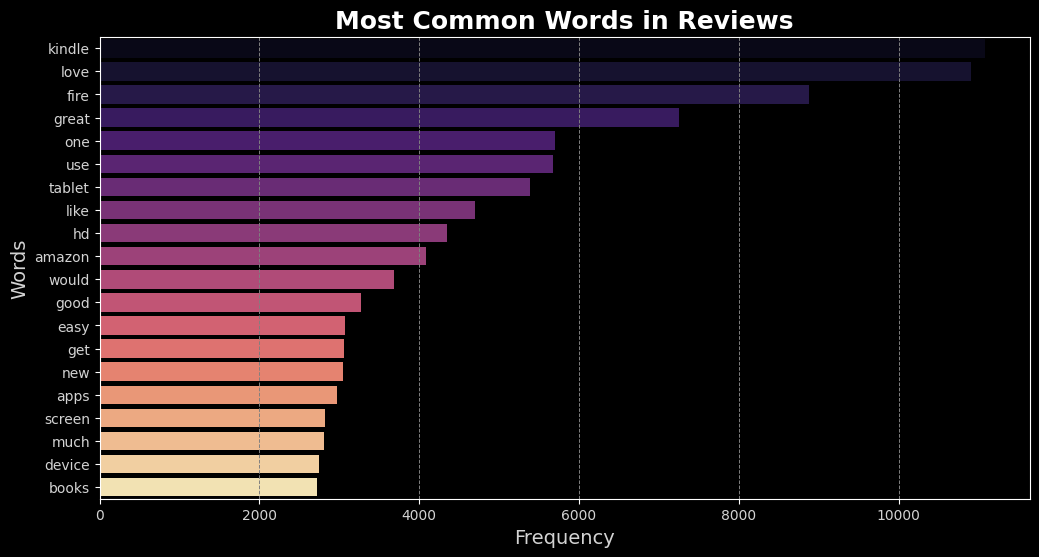

In [71]:
# 5. Most Common Words
# Tokenize the cleaned review body
all_words = ' '.join(data['cleaned_review_body']).split()

# Count the frequency of each word
word_counts = Counter(all_words)

# Get the most common words (e.g., top 20)
most_common_words = word_counts.most_common(20)

# Create a DataFrame from the most common words
common_words_df = pd.DataFrame(most_common_words, columns=['Word', 'Frequency'])

# Plot the most common words with a vibrant color palette and custom styling
plt.figure(figsize=(12, 6))
sns.barplot(x='Frequency', y='Word', data=common_words_df, hue='Word', palette='magma', errorbar=None, legend=False)
plt.title('Most Common Words in Reviews', fontsize=18, fontweight='bold', color='white')
plt.xlabel('Frequency', fontsize=14, color='lightgray')
plt.ylabel('Words', fontsize=14, color='lightgray')
plt.grid(axis='x', color='gray', linestyle='--', linewidth=0.7)
plt.xticks(color='lightgray')
plt.yticks(color='lightgray')
plt.gca().set_facecolor('black')  # Set the background color to black
plt.show()


### **Step 5: Feature Extraction and Text Processing** ###

In [75]:
# Function to clean text data
def clean_text(text):
    # Remove HTML tags and special characters
    text = re.sub(r'<.*?>', '', text)  # Remove HTML tags
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
    text = re.sub(r'\d+', '', text)      # Remove numbers
    text = text.lower()                   # Convert to lowercase
    
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    text = ' '.join([word for word in text.split() if word not in stop_words])
    
    return text

# Apply the clean_text function to 'review_body'
data['cleaned_review_body'] = data['review_body'].apply(clean_text)

In [76]:
# Initialise the TF-IDF Vectorizer
vectorizer = TfidfVectorizer(max_features=5000)  # You can adjust max_features as needed

# Fit and transform the cleaned review body
X = vectorizer.fit_transform(data['cleaned_review_body'])

# Convert the sparse matrix to a DataFrame for easier handling (optional)
tfidf_df = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names_out())

# Display the shape of the TF-IDF matrix and the first few features
print("Shape of TF-IDF matrix:", X.shape)
print("First few features:\n", tfidf_df.head())

Shape of TF-IDF matrix: (30840, 5000)
First few features:
    abc  abilities  ability  able  absolute  absolutely  abundance  abuse  \
0  0.0        0.0      0.0   0.0       0.0         0.0        0.0    0.0   
1  0.0        0.0      0.0   0.0       0.0         0.0        0.0    0.0   
2  0.0        0.0      0.0   0.0       0.0         0.0        0.0    0.0   
3  0.0        0.0      0.0   0.0       0.0         0.0        0.0    0.0   
4  0.0        0.0      0.0   0.0       0.0         0.0        0.0    0.0   

   abysmal   ac  ...  youtube  youtubecom  youve   yr  yrs  yup  zero  zinio  \
0      0.0  0.0  ...      0.0         0.0    0.0  0.0  0.0  0.0   0.0    0.0   
1      0.0  0.0  ...      0.0         0.0    0.0  0.0  0.0  0.0   0.0    0.0   
2      0.0  0.0  ...      0.0         0.0    0.0  0.0  0.0  0.0   0.0    0.0   
3      0.0  0.0  ...      0.0         0.0    0.0  0.0  0.0  0.0   0.0    0.0   
4      0.0  0.0  ...      0.0         0.0    0.0  0.0  0.0  0.0   0.0    0.0   

   

### **Step 6: Model Selection and Model Training** ###

In [78]:
# 1. Prepare the Data
# Assuming 'data' contains the sentiment labels and the TF-IDF features are stored in 'X'
# Define the features (X) and target labels (y)
X = vectorizer.fit_transform(data['cleaned_review_body'])
y = data['sentiment']  # This should be your sentiment labels

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [79]:
# 2. Train the Logistic Regression Model

# Initialise the logistic regression model
model = LogisticRegression(max_iter=1000)  # Increase max_iter if necessary

# Fit the model on the training data
model.fit(X_train, y_train)


LogisticRegression(max_iter=1000)

In [80]:
# 3. Make Predictions

# Make predictions on the test set
y_pred = model.predict(X_test)


### **Step 7: Model Evaluation** ###

In [89]:
# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')

# Calculate precision
precision = precision_score(y_test, y_pred, average='weighted')
print(f'Precision: {precision:.2f}')

# Calculate recall
recall = recall_score(y_test, y_pred, average='weighted')
print(f'Recall: {recall:.2f}')

# Calculate F1 score
f1 = f1_score(y_test, y_pred, average='weighted')
print(f'F1 Score: {f1:.2f}')

# Generate a classification report
report = classification_report(y_test, y_pred)
print("Classification Report:\n", report)

Accuracy: 0.90
Precision: 0.90
Recall: 0.90
F1 Score: 0.89
Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.56      0.65      1027
           1       0.92      0.97      0.94      5141

    accuracy                           0.90      6168
   macro avg       0.86      0.76      0.80      6168
weighted avg       0.90      0.90      0.89      6168



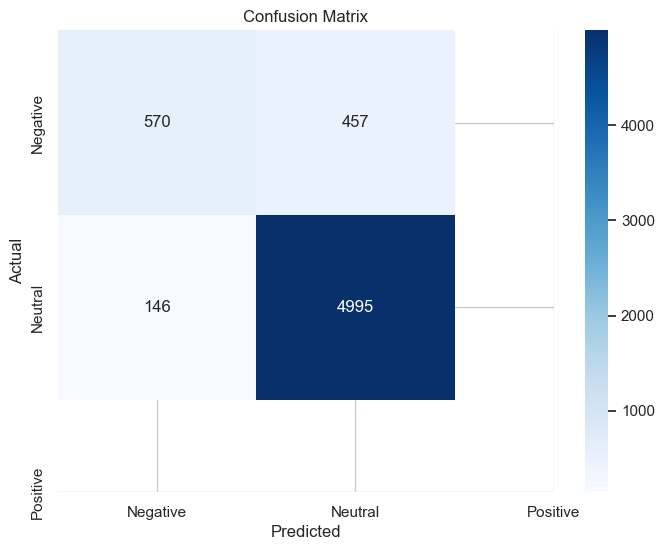

In [90]:
# Generate the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Negative', 'Neutral', 'Positive'],
            yticklabels=['Negative', 'Neutral', 'Positive'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

### **Step 8: Performance Metrics** ###

Feature importance:
           Feature  Coefficient  Importance
2579          luck     8.134635    8.134635
1888        greedy     5.990563    5.990563
2585         lunch     5.422270    5.422270
1149     disabling    -5.377063    5.377063
3730           rip    -4.200505    4.200505
1289        easier     4.176789    4.176789
330        average     4.066924    4.066924
3151       perform     3.726747    3.726747
3729         right    -3.604839    3.604839
168   alternatives     3.562776    3.562776


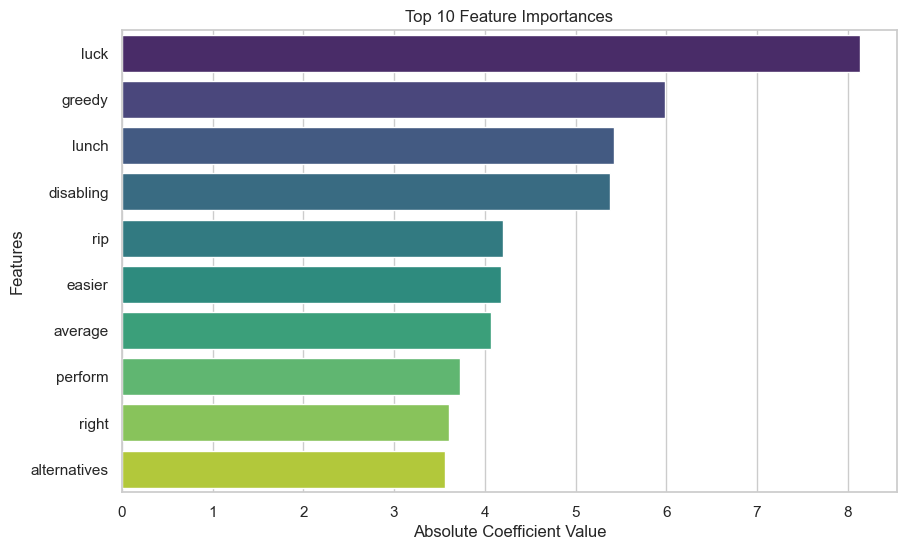

In [92]:
# Model Interpretation
if hasattr(model, 'coef_'):
    # Get feature names from the vectorizer
    feature_names = tfidf_vectorizer.get_feature_names_out()
    
    # Get the coefficients
    coefficients = model.coef_[0]

    # Create a DataFrame to display feature importance
    importance_df = pd.DataFrame({'Feature': feature_names, 'Coefficient': coefficients})

    # Calculate absolute importance and sort
    importance_df['Importance'] = np.abs(importance_df['Coefficient'])
    importance_df = importance_df.sort_values(by='Importance', ascending=False)

    # Display feature importance
    print("Feature importance:")
    print(importance_df.head(10))  # Display top 10 features

    # Visualisation of feature importance
    plt.figure(figsize=(10, 6))
    sns.barplot(data=importance_df.head(10), x='Importance', y='Feature', palette='viridis')
    plt.title('Top 10 Feature Importances')
    plt.xlabel('Absolute Coefficient Value')
    plt.ylabel('Features')
    plt.show()
else:
    print("Model has not been fitted correctly.")

In [93]:
# Save the model
joblib.dump(model, 'sentiment_model.pkl')

['sentiment_model.pkl']

In [94]:
model = joblib.load(r"C:\Users\USER\Downloads\Sentiment Analysis for Product Reviews\sentiment_model.pkl")
tfidf_vectorizer = joblib.load(r"C:\Users\USER\Downloads\Sentiment Analysis for Product Reviews\vectorizer.pkl")